In [1]:
import requests
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import config
import logging
import importlib
import time
import random
from selenium import webdriver
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException
import validators
import pickle
import time
import random
from calendar import monthrange
import re
import spacy
from spacy.tokens import Doc, Span
import nltk
from nltk.corpus import stopwords
from nltk.corpus import treebank
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import wordnet

from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

pd.options.display.max_columns = 300
import string
import unicodedata

pd.options.display.max_columns = 200
pd.options.display.max_rows = 999
import matplotlib.pyplot as plt  

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
import pandas as pd
import numpy as np
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC  
from time import time
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer


import gensim
from gensim import corpora
from gensim import models
from gensim.sklearn_api import lsimodel, ldamodel
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

import pyLDAvis
import pyLDAvis.gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from functools import partial
from operator import itemgetter

/Users/markbrennan/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/markbrennan/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Classes and Functions for our pre-processing

In [29]:
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, language='english', source=None):
        self.source = source
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.more_stops = {'mr', 'ms', 'mr.', 'ms.', 'mrs', 'mrs.','say', 'said', 'saying', 
                           'also', 'yeh', 'hom', 'even', 'like', 'k', 'n', 'u', 'would', 'could', '$'}
        self.stopwords.update(self.more_stops) 
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(unicodedata.category(char).startswith('P') for char in token)

    def is_stopword(self, token):
        return token.lower() in self.stopwords
    
    def get_stopwords(self):
        return self.stopwords

    def get_wordnet_pos(selfm, word):
        #Map POS tag to first character lemmatize() 
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    def normalize(self, document):
        NYT_PAT = '^[A-Z]* — '
        NYT_COMP_PAT = re.compile(NYT_PAT)        
        
        norm_toks = []
    
        if self.source and self.source == 'NYT':
            document = NYT_COMP_PAT.sub('', document)
# I found nltk's sentenizer to perform poorly
#        for sent in sent_tokenize(document):
        for sent in document.split('.'):            
            for tok in nltk.word_tokenize(sent):
                if self.is_punct(tok) or tok.isdigit():
                    continue
                lem = self.lemmatize(tok, self.get_wordnet_pos(tok)).lower()
                if not self.is_stopword(lem):
                    norm_toks.append(lem) 
                
        return norm_toks


    def lemmatize(self, token, pos):
        return self.lemmatizer.lemmatize(token, pos)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for doc in documents:
            yield self.normalize(document)

## Custom (domain-specific) Bi-Grams and a bi-gram transformer class

In [30]:
# code to pull out our custom bi-grams
bigrams = ['donald trump', 'angela merkel', 'boris johnson', 'vladimir putin', 'benjamin netanyahu', 
           'hong kong', 'north korea', 'south korea', 'united kingdom', 'united states', 'south africa', 
           'xi jinping', 'carrie lam', 'oleksiy honcharuk', 'volodymyr zelensky', 'emmanuel macron',
           'viktor orbán', 'justin trudeau', 'north america', 'south america', 'sinn fein', 'jeremy corbyn', 'narendra modi',
            'mohamed morsi', 'shuping wang', 'hassan rouhani', 'rudy giuliani', 'joe biden', 'new zealand', 'european union', 'pope francis']

In [31]:
class BiGramTransformer:
    def __init__(self, bigram_list):
        self.bigram_list = bigram_list        
        self.first_grams = [word.split()[0] for word in bigram_list]
        self.second_grams = [word.split()[1] for word in bigram_list]

    def get_custom_bigrams(self, tokens):
        new_toks = []
        length = len(tokens)

        for ix, tok in enumerate(tokens):
            try:
                if tok in self.first_grams:
                    if ix+1 <= length and tokens[ix+1] in self.second_grams:
                        new_toks.append(' '.join([tok, tokens[ix+1]]))
                        continue
                if tok in self.second_grams:
                    # we assume if we see the 2nd token in a bigram that
                    # we've already prcessed the first and second together
                    # so skip 
                    continue
                new_toks.append(tok)
            except IndexError:
                continue

        return new_toks

## Some articles have kanji, so we need to identify them and then remove

In [32]:
def get_kanji_text_rows(df):
    kanji_pat = re.compile(u'[\u4e00-\u9fff]') 
    kanji_rows = []
    for i in range(0, len(df)):
        text = df.iloc[i].text
        if type(text) is not str:
            continue
        if  kanji_pat.search(df.iloc[i].text):
            kanji_rows.append(i)
            
    return kanji_rows

## Read in our Financial Times (FT) data

In [33]:
ft_df = pd.read_csv('ALL_FT_WORLD.csv')

,Unnamed: 0,date,headline,paper,section,text,url,norm_text,full_norm_text
0,0,2019-10-13,Argentina’s economic woes spell doom for Macri...,FT,World,Argentina’s president Mauricio Macri sounded a...,https://www.ft.com/content/59e751c0-e8f6-11e9-...,"['argentina', 'president', 'mauricio', 'macri'...",argentina president mauricio macri sounded alm...
1,1,2019-10-13,Iran: hardliners’ anti-graft drive masks wider...,FT,World,It wasn’t his “luxury” house that made Iranian...,https://www.ft.com/content/d0fe931e-d946-11e9-...,"['luxury', 'house', 'made', 'iranians', 'sit',...",luxury house made iranians sit notice even top...
2,2,2019-10-13,Private schools/Labour: Eton disorder,FT,World,"Eton, its former head liked to point out, is a...",https://www.ft.com/content/eea3e139-6cbf-477a-...,"['eton', 'former', 'head', 'liked', 'point', '...",eton former head liked point four-letter word ...
3,3,2019-10-13,Investment pot overflows as Germany’s infrastr...,FT,World,The Fritz Karsen school in Berlin is in dire n...,https://www.ft.com/content/a8e535e0-e837-11e9-...,"['fritz', 'karsen', 'school', 'berlin', 'dire'...",fritz karsen school berlin dire need makeover ...
4,4,2019-10-13,Yorkshire Post tests the value of trust in div...,FT,World,At a time when the UK’s main political parties...,https://www.ft.com/content/97fd36f8-df89-11e9-...,"['time', 'uk', 'main', 'political', 'party', '...",time uk main political party never apart might...


In [34]:
ft_df.drop(axis=1, columns=['Unnamed: 0', 'norm_text', 'full_norm_text'], inplace=True)

In [35]:
ft_df.head()

,date,headline,paper,section,text,url
0,2019-10-13,Argentina’s economic woes spell doom for Macri...,FT,World,Argentina’s president Mauricio Macri sounded a...,https://www.ft.com/content/59e751c0-e8f6-11e9-...
1,2019-10-13,Iran: hardliners’ anti-graft drive masks wider...,FT,World,It wasn’t his “luxury” house that made Iranian...,https://www.ft.com/content/d0fe931e-d946-11e9-...
2,2019-10-13,Private schools/Labour: Eton disorder,FT,World,"Eton, its former head liked to point out, is a...",https://www.ft.com/content/eea3e139-6cbf-477a-...
3,2019-10-13,Investment pot overflows as Germany’s infrastr...,FT,World,The Fritz Karsen school in Berlin is in dire n...,https://www.ft.com/content/a8e535e0-e837-11e9-...
4,2019-10-13,Yorkshire Post tests the value of trust in div...,FT,World,At a time when the UK’s main political parties...,https://www.ft.com/content/97fd36f8-df89-11e9-...


## Get kanji rows and then remove

In [36]:
ft_df.drop(get_kanji_text_rows(ft_df), inplace=True)

## Drop all NAs

In [37]:
ft_df.dropna(inplace=True)

In [17]:
# WRITE A FUNCTION TO DO THIS PRE_PROCESSING!

## Instantiate our text normalizer and apply normalization to the text rows

In [38]:
ft_normer = TextNormalizer()

In [39]:
ft_df['norm_text'] = ft_df.text.apply(ft_normer.normalize)

## Instantiate and run our new bigram transformer

In [40]:
bigram_t = BiGramTransformer(bigrams)

In [41]:
ft_df['bigrammed_text'] = ft_df.norm_text.apply(bigram_t.get_custom_bigrams)

## Save our NYT dataframe

In [52]:
with open('clean_ft.pkl', 'wb') as f:
    pickle.dump(ft_df, f)

## Try SKlearn CountVectorizer and TFIDF and extract feature names (borrowed from https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#Computing-TF-IDF-and-Extracting-Keywords)

In [107]:
# Gonna use our test NYT DF

In [108]:
test_nyt_df['full_norm_text'] = test_nyt_df.norm_text.apply(lambda x: ' '.join(x))

In [112]:
cv = CountVectorizer(max_df=0.85, stop_words=nyt_normer.stopwords, max_features=10000)

word_count_vector = cv.fit_transform(test_nyt_df.full_norm_text) 


In [114]:
list(cv.vocabulary_.keys())[:50]

['rabat',
 'morocco',
 'moroccan',
 'judge',
 'monday',
 'found',
 'journalist',
 'fiancé',
 'guilty',
 'premarital',
 'sex',
 'obtain',
 'abortion',
 'impose',
 'prison',
 'sentence',
 'doctor',
 'convict',
 'perform',
 'case',
 'critic',
 'denounce',
 'thinly',
 'veil',
 'bid',
 'suppress',
 'critical',
 'coverage',
 'government',
 'hajar',
 'raissouni',
 'work',
 'independent',
 'daily',
 'newspaper',
 'akhbar',
 'al',
 'yaoum',
 'rifaat',
 'amin',
 'arrest',
 'aug',
 'leave',
 'gynecologist',
 'office',
 'capital',
 'defendant',
 'deny',
 'take',
 'place']

In [117]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [118]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    
    return results

In [119]:
# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names()
 
# get the document that we want to extract keywords from
doc = test_nyt_df.iloc[0].full_norm_text
 
#generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
 
#sort the tf-idf vectors by descending order of scores
sorted_items = sort_coo(tf_idf_vector.tocoo())
 
#extract only the top n; n here is 10
keywords = extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\n=====Doc=====")
print(doc)
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


=====Doc=====
rabat morocco moroccan judge monday found journalist fiancé guilty premarital sex obtain abortion impose prison sentence doctor convict perform abortion case critic denounce thinly veil bid suppress critical coverage government journalist hajar raissouni work independent daily newspaper akhbar al yaoum fiancé rifaat al-amin arrest aug leave gynecologist office moroccan capital rabat defendant deny abortion take place raissouni sought treatment suffer blood clot judgment come shock cherki lahrech journalist present verdict defense prove innocence understand happen pose many question judge sentence raissouni al-amin one year prison dr jamal belkeziz two year second doctor office assistant found guilty take part procedure judge give suspend sentence raissouni wear black traditional robe know djellaba head scarf show outward reaction verdict drew cry gasp others courtroom several friend huddle nearby afterward cry console wave goodbye put police vehicle driven away courthous

## Gensim LDA:  create our dictionary, corpus, and fit our LDA model

In [43]:
lexicon = Dictionary([[word for word in doc] for doc in ft_df.bigrammed_text])
# lexicon.filter_extremes(no_below=5, no_above=0.5, keep_n=1)
corpus = [lexicon.doc2bow(doc) for doc in ft_df.bigrammed_text]
model = models.LdaModel(corpus, id2word=lexicon, num_topics=12)

## Save our LDA (for NYT)

In [44]:
model.save('ft_lda.model')

## Now visualize our results

In [45]:
data = pyLDAvis.gensim.prepare(model, corpus, lexicon)
pyLDAvis.display(data)

In [50]:
id2token = lexicon.id2token

for word_id, freq in next(iter(corpus)):
    print(id2token[word_id], freq)
    # get the highest weighted topic for each of the documents in the corpus

def get_topics(vectorized_corpus, model):
    topics = [
                max(model[doc], key=itemgetter(1))[0]
                for doc in vectorized_corpus]
    return topics

topics = get_topics(corpus, model)
for topic, doc in zip(topics, nyt_df.bigrammed_text):
    print("Topic:{}".format(topic))
    print(doc)

25th 1
57bn 1
930,000 1
able 1
acclamation 1
accurate 1
act 1
add 1
address 1
administration 1
admit 1
advance 1
aide 1
aires 4
alberto 2
almost 2
already 3
another 3
anyone 1
anything 2
apologetic 1
appeal 1
approach 1
argentina 5
argentine 2
argentines 1
asset 1
attack 1
august 1
avoid 1
awada 1
back 3
bad 3
bailout 1
banker 1
banner 1
barely 1
barometer 1
baron 1
base 3
batter 1
behind 1
believe 1
best 1
beyond 1
bidding 1
big 1
black 1
bloomberg 1
blow 1
buenos 4
business 1
businesswoman 1
cambiemos 1
campaign 6
candidate 3
case 1
caution 1
chair 1
change 1
chaotic 1
charisma 1
cheer 1
chime 1
city 2
civil 1
clad 1
close 1
coalition 1
come 3
comfort 1
competent 1
completely 1
comprehend 1
consecutive 1
consultant 1
contract 1
contrition 1
control 2
corruption 2
country 4
coup 1
courtesy 1
crash 1
credibility 1
cristina 1
crowd 3
culture 1
de 2
debt 1
december 1
defeat 2
deflate 1
democracy 1
department 1
described 1
designer 2
despairingly 1
devaluation 1
developer 1
different 2
di

NameError: name 'nyt_df' is not defined

In [ ]:
print(model.print_topics(10))

In [ ]:
tfidf = TfidfModel([lexicon.doc2bow(doc) for doc in nyt_df.norm_text], id2word=lexicon)

[(6, '0.007*"pakistan" + 0.006*"kashmir" + 0.006*"government" + 0.005*"hong" + 0.005*"kong" + 0.005*"china" + 0.004*"would" + 0.004*"year" + 0.004*"people" + 0.004*"india"'), (4, '0.010*"government" + 0.006*"people" + 0.005*"year" + 0.005*"united" + 0.005*"kashmir" + 0.004*"china" + 0.004*"one" + 0.004*"many" + 0.004*"kong" + 0.004*"take"'), (1, '0.008*"hong" + 0.007*"kong" + 0.005*"people" + 0.004*"protester" + 0.004*"united" + 0.004*"government" + 0.004*"one" + 0.004*"many" + 0.004*"china" + 0.004*"police"'), (8, '0.007*"government" + 0.006*"people" + 0.004*"one" + 0.004*"year" + 0.004*"new" + 0.003*"many" + 0.003*"kashmir" + 0.003*"would" + 0.003*"police" + 0.003*"country"'), (2, '0.007*"united" + 0.006*"states" + 0.005*"would" + 0.005*"new" + 0.005*"people" + 0.005*"year" + 0.004*"government" + 0.004*"missile" + 0.004*"country" + 0.004*"american"'), (5, '0.007*"government" + 0.007*"would" + 0.005*"united" + 0.005*"year" + 0.004*"official" + 0.004*"group" + 0.004*"one" + 0.004*"peop

abdeslam 1
abolish 1
abortion 7
activism 1
africa 1
afterward 1
ago 1
akhbar 3
al 3
al-amin 2
allow 1
amendment 1
amnesty 1
anti-abortion 1
apparently 1
appeal 1
arab 1
arbitrary 1
arrest 5
ask 1
assault 1
assistant 1
aug 1
authority 1
away 1
base 1
belkeziz 1
bid 1
black 1
blood 1
bouachrine 1
call 2
campaign 1
capital 1
case 5
caught 1
chance 1
change 1
charge 6
cherki 1
cite 1
clearly 1
clooney 1
clot 1
coast 1
code 1
come 1
commentary 1
complaint 1
conclude 1
conservative 1
consider 1
console 1
continued 1
convict 1
could 1
country 3
court 1
courthouse 1
courtroom 1
cover 1
coverage 1
critic 2
critical 3
criticism 1
cry 2
currently 1
daily 1
day 1
defendant 1
defense 1
demand 1
demonstration 1
denounce 2
deny 1
detention 1
director 1
dissent 1
djellaba 1
doctor 2
dr 1
drew 1
driven 1
enforce 1
enforcement 1
ensure 1
evidence 1
example 1
expect 1
expert 1
fiancé 2
figure 1
file 1
found 2
foundation 1
founder 1
freedom 2
friend 1
gasp 1
geneva-based 1
give 1
goodbye 1
govern 1
govern

In [ ]:
with open('gensim_data3.pkl', 'wb') as f:
    pickle.dump(data, f)
   

In [51]:
pyLDAvis.save_html(data, 'nft_full_lda.html')

In [ ]:
model.show_topic

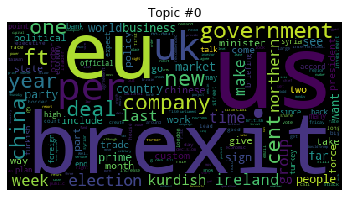

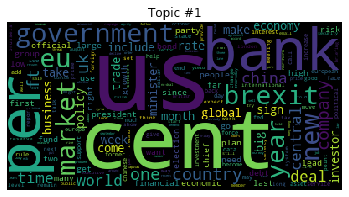

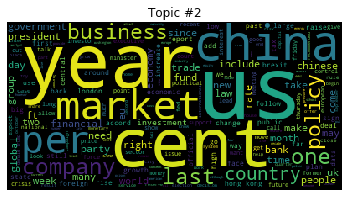

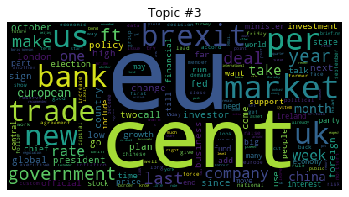

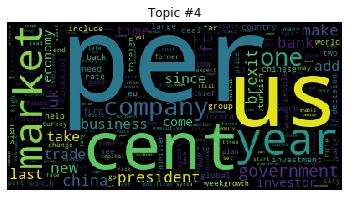

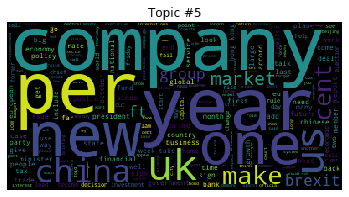

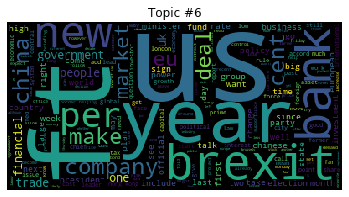

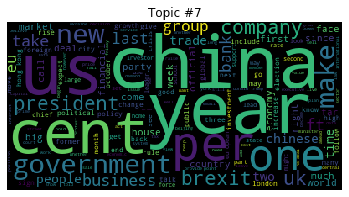

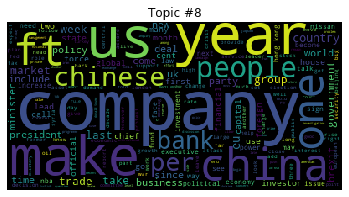

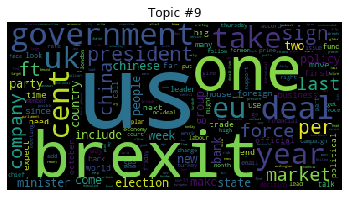

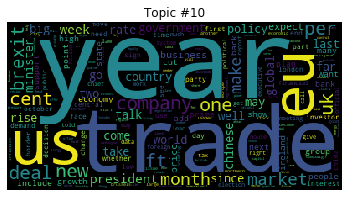

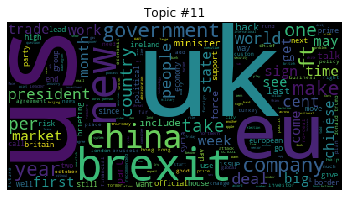

In [49]:
for t in range(model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))

    plt.show()